In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.linalg import eigvalsh
import math

In [2]:
data = pd.read_parquet('data/Qwen/data_qwen_complete.parquet', engine='pyarrow')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 1 to 300
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Text_EN                   300 non-null    object 
 1   Text_PL                   300 non-null    object 
 2   Text_RU                   300 non-null    object 
 3   Translation_quality       300 non-null    float64
 4   Qwen_far_right_EN_answer  300 non-null    int64  
 5   Qwen_far_right_PL_answer  300 non-null    int64  
 6   Qwen_far_right_RU_answer  300 non-null    int64  
 7   Qwen_mod_cons_EN_answer   300 non-null    int64  
 8   Qwen_mod_cons_PL_answer   300 non-null    int64  
 9   Qwen_mod_cons_RU_answer   300 non-null    int64  
 10  Qwen_prog_left_EN_answer  300 non-null    int64  
 11  Qwen_prog_left_PL_answer  300 non-null    int64  
 12  Qwen_prog_left_RU_answer  300 non-null    int64  
 13  Qwen_centrist_EN_answer   300 non-null    int64  
 14  Qwen_centr

In [4]:
qwen_cols = [col for col in data if col.startswith('Qwen')]

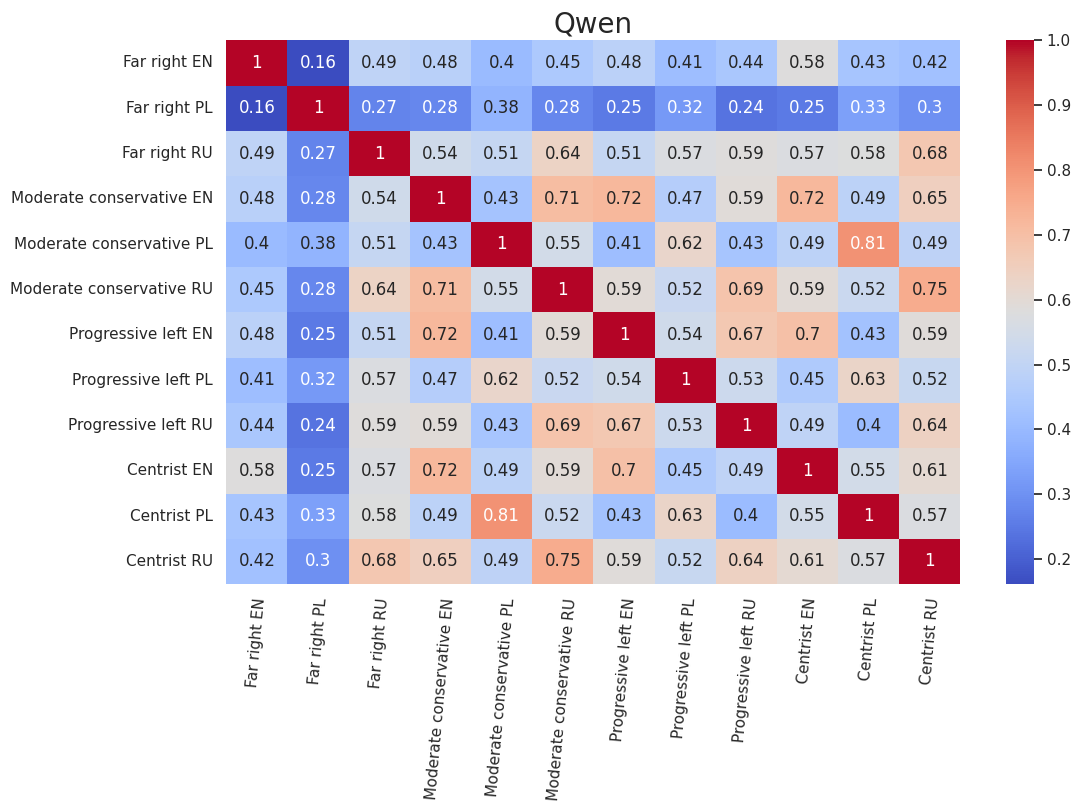

In [5]:


# Convert None values to NaN which pandas recognizes
new_data = data[data['Translation_quality'] == 1.0].drop(['Translation_quality'], axis=1)[qwen_cols].replace([None], np.nan)

# Calculate correlation - by default this uses pairwise deletion
# which means each correlation is calculated using all rows where both columns have values
corr = new_data.corr(method='pearson')

# Set up the plot
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

ticks = ['Far right EN', 'Far right PL',
       'Far right RU', 'Moderate conservative EN',
       'Moderate conservative PL', 'Moderate conservative RU',
       'Progressive left EN', 'Progressive left PL',
       'Progressive left RU', 'Centrist EN',
       'Centrist PL', 'Centrist RU']

# Create the heatmap
plot = sns.heatmap(corr, 
            xticklabels=ticks,
            yticklabels=ticks, 
            annot=True,
            cmap="coolwarm")

plot.set_xticklabels(plot.get_xticklabels(), rotation=85)
plot.set_title('Qwen', fontsize=20)

plt.tight_layout()

plt.savefig('data/Qwen/correlation_plot_mistral.png', format='png', bbox_inches='tight')
plt.show()

In [7]:
R_gemma = corr.values    # now R_gemma[i,j] works with integer i,j

def cross_lang_consistency(R):
    personas = {
        'Far-Right': [0,1,2],
        'Mod-Con':   [3,4,5],
        'Prog-Left': [6,7,8],
        'Centrist':  [9,10,11]
    }
    avgs = []
    for idxs in personas.values():
        avgs.append(np.mean([R[i,j] for i,j in combinations(idxs,2)]))
    return np.mean(avgs)

def separation_score(R):
    personas = {
        'Far-Right': [0,1,2],
        'Mod-Con':   [3,4,5],
        'Prog-Left': [6,7,8],
        'Centrist':  [9,10,11]
    }
    within = []
    between = []
    all_idx = range(R.shape[0])
    for name, idxs in personas.items():
        for i,j in combinations(idxs,2):
            within.append(R[i,j])
    for i,j in combinations(all_idx,2):
        # find which persona each index belongs to
        gi = next(g for g,idxs in personas.items() if i in idxs)
        gj = next(g for g,idxs in personas.items() if j in idxs)
        if gi != gj:
            between.append(R[i,j])
    return np.mean(within) - np.mean(between)

def effective_rank(R):
    lam = eigvalsh(R)
    p = lam / lam.sum()
    H = -np.sum(p * np.log(p + 1e-20))
    return math.exp(H)

# 4) Compute and compare
for name, R in [('Qwen', R_gemma)]:  # add ('Mistral', R_mistral) once you load it
    print(f"{name}:")
    print("  Cross-lang consistency:", cross_lang_consistency(R))
    print("  Separation score S:    ", separation_score(R))
    print("  Effective rank:        ", effective_rank(R))


Qwen:
  Cross-lang consistency: 0.5059793226818462
  Separation score S:     0.00016256239860379385
  Effective rank:         5.303171144736138


In [8]:
import numpy as np
import pandas as pd

# 1) Labels in order
labels = [
    "Far-Right EN","Far-Right PL","Far-Right RU",
    "Mod-Con EN","Mod-Con PL","Mod-Con RU",
    "Prog-Left EN","Prog-Left PL","Prog-Left RU",
    "Centrist EN","Centrist PL","Centrist RU"
]

# 2) Parameters
r_within  = 1.0   # same group
r_between = 0.4   # different groups

# 3) Build full matrix filled with r_between
R = np.full((12,12), r_between)

# 4) Overwrite each 3×3 block on the diagonal to r_within
for start in (0,3,6,9):
    R[start:start+3, start:start+3] = r_within

# 5) Ensure exact 1s on the diagonal
np.fill_diagonal(R, 1.0)

# 6) Wrap in DataFrame for readability
df_ideal = pd.DataFrame(R, index=labels, columns=labels)
print(df_ideal)


              Far-Right EN  Far-Right PL  Far-Right RU  Mod-Con EN  \
Far-Right EN           1.0           1.0           1.0         0.4   
Far-Right PL           1.0           1.0           1.0         0.4   
Far-Right RU           1.0           1.0           1.0         0.4   
Mod-Con EN             0.4           0.4           0.4         1.0   
Mod-Con PL             0.4           0.4           0.4         1.0   
Mod-Con RU             0.4           0.4           0.4         1.0   
Prog-Left EN           0.4           0.4           0.4         0.4   
Prog-Left PL           0.4           0.4           0.4         0.4   
Prog-Left RU           0.4           0.4           0.4         0.4   
Centrist EN            0.4           0.4           0.4         0.4   
Centrist PL            0.4           0.4           0.4         0.4   
Centrist RU            0.4           0.4           0.4         0.4   

              Mod-Con PL  Mod-Con RU  Prog-Left EN  Prog-Left PL  \
Far-Right EN         

In [10]:
R_gemma = df_ideal.values    # now R_gemma[i,j] works with integer i,j

def cross_lang_consistency(R):
    personas = {
        'Far-Right': [0,1,2],
        'Mod-Con':   [3,4,5],
        'Prog-Left': [6,7,8],
        'Centrist':  [9,10,11]
    }
    avgs = []
    for idxs in personas.values():
        avgs.append(np.mean([R[i,j] for i,j in combinations(idxs,2)]))
    return np.mean(avgs)

def separation_score(R):
    personas = {
        'Far-Right': [0,1,2],
        'Mod-Con':   [3,4,5],
        'Prog-Left': [6,7,8],
        'Centrist':  [9,10,11]
    }
    within = []
    between = []
    all_idx = range(R.shape[0])
    for name, idxs in personas.items():
        for i,j in combinations(idxs,2):
            within.append(R[i,j])
    for i,j in combinations(all_idx,2):
        # find which persona each index belongs to
        gi = next(g for g,idxs in personas.items() if i in idxs)
        gj = next(g for g,idxs in personas.items() if j in idxs)
        if gi != gj:
            between.append(R[i,j])
    return np.mean(within) - np.mean(between)

import numpy as np

def effective_rank(R):
    # 1) Compute eigenvalues of the symmetric matrix
    lam = np.linalg.eigvalsh(R)

    # 2) Clip any small negative values (numerical noise) to exactly zero
    lam = np.clip(lam, 0, None)

    # 3) Compute total variance and bail out if it's zero
    total = lam.sum()
    if total <= 0:
        # no variance at all, degenerate matrix
        return np.nan

    # 4) Normalize to a probability vector
    p = lam / total

    # 5) Keep only the positive entries (drop the zeros)
    p = p[p > 0]

    # 6) Compute Shannon entropy
    H = -np.sum(p * np.log(p))

    # 7) Exponentiate to get the effective rank
    return np.exp(H)


# 4) Compute and compare
for name, R in [('Qwen', R_gemma)]:  # add ('Mistral', R_mistral) once you load it
    print(f"{name}:")
    print("  Cross-lang consistency:", cross_lang_consistency(R))
    print("  Separation score S:    ", separation_score(R))
    print("  Effective rank:        ", effective_rank(R))


Qwen:
  Cross-lang consistency: 1.0
  Separation score S:     0.6000000000000001
  Effective rank:         3.262567113465002
